In [21]:
import pandas as pd
import vertica_python
import sqlalchemy as sa
%matplotlib inline

In [22]:
# engine_info = "vertica+vertica_python://" + conn_info['user'] + ":" + conn_info['password'] + "@" + "vertica.getbux.com" + ":5433/" + conn_info['database'] 
# engine = sa.create_engine(engine_info)


# cur = connection.cursor()
# cur.execute("SELECT * FROM TABLE")
# result = cur.fetchall()
# connection.close()

# from sqlalchemy.engine import url as sa_url
# from sqlalchemy import create_engine
# db_connect_url = sa_url.URL(
#             drivername='vertica+pyodbc',
#             username='josolnik',
#             password='CXw!CHeDa@N6hGQ8',
#             host='vertica.getbux.com',
#             port=5433,
#             database='buxdwh',
# )
# create_engine(db_connect_url)

In [23]:
conn_info = {'host': 'vertica.getbux.com',
              'port': 5433,
              'user': 'josolnik',
              'password': 'CXw!CHeDa@N6hGQ8',
              'database': 'buxdwh',
              # 10 minutes timeout on queries
              'read_timeout': 600,
              # default throw error on invalid UTF-8 results
              'unicode_error': 'strict',
              # SSL is disabled by default
              'ssl': False,
              'connection_timeout': 5
              # connection timeout is not enabled by default
           }

# # simple connection, with manual close
conn = vertica_python.connect(**conn_info)
cur = conn.cursor('dict')

In [24]:
def sql_query(query_string): # columns):
    cur.execute(query_string)
    df = pd.DataFrame(cur.fetchall())
    # df.columns = columns
    return df

### Users

In [25]:
user_columns = ['user_id', 'country_cd', 'gender', 'nationality', 'platform_type_name', 'trading_experience', 'title', 'network', 'bux_account_created_dts', 'account_type', 'ams_first_funded_dts', 'initial_deposit_amount', 'sum_deposits', 'cnt_deposits']

query_users = """ 

        SELECT user_id, country_cd, gender, nationality, platform_type_name, trading_experience, title, network, bux_account_created_dts, account_type, ams_first_funded_dts, initial_deposit_amount, sum_deposits, cnt_deposits
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2017-02-01' AND '2017-03-01'

        """
users = sql_query(query_users)
# users.columns = user_columns

In [26]:
users.head()

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,account_type,ams_first_funded_dts,initial_deposit_amount,sum_deposits,cnt_deposits
0,031b0f17-9a45-4b1b-b7b4-027802ffad95,DE,MALE,DE,iOS,SOME,Experienced Trader,Appnext,2017-02-03 21:10:20.056,SERIOUS_BUX,2017-02-13 22:11:52,450.0000000,450.0000000,1.0
1,010e236f-8ab5-4681-a146-273531d19d54,AT,None,None,Android,NONE,Rookie Trader,Organic,2017-02-01 16:33:27.777,FUN_BUX,NaT,None,None,NaN
2,011f6526-ab7e-4790-b289-5fa1faf69bc3,AT,None,None,Android,NONE,Rookie Trader,Viral Invites,2017-02-26 11:55:06.928,FUN_BUX,NaT,None,None,NaN
3,0231bd62-6733-4f8b-9c57-87f4eb9e0aa1,AT,None,None,Android,NONE,Rookie Trader,Facebook Installs,2017-02-17 23:14:11.280,FUN_BUX,NaT,None,None,NaN
4,028e03b9-ab6d-4ede-85f2-ce6b6e38ad47,AT,None,None,Android,NONE,Rookie Trader,Facebook Installs,2017-02-20 10:30:34.584,FUN_BUX,NaT,None,None,NaN


In [27]:
users.to_csv('data/users_Feb_1_30days_cohort.csv')

In [28]:
len(users)

58839

### USERS EDA

In [29]:
def column_summary(column_name, limit=False):
    if limit:
        df = pd.DataFrame(users[column_name].value_counts()).sort_values(by=column_name, ascending=False)[0:limit]
        plot = df.plot(kind='bar')
        return plot, df

,sum_deposits
50.0000000,756
100.0000000,354
150.0000000,131
200.0000000,107
250.0000000,76
300.0000000,65
500.0000000,64
350.0000000,38
400.0000000,36
1000.0000000,33


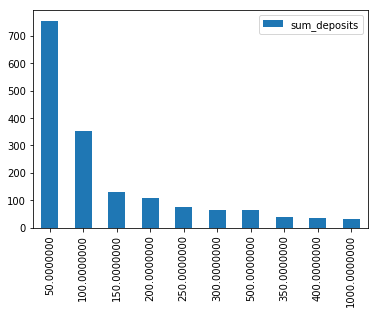

In [30]:
df, plot = column_summary('sum_deposits', 10);
df
plot

,account_type
FUN_BUX,57393
SERIOUS_BUX,1446


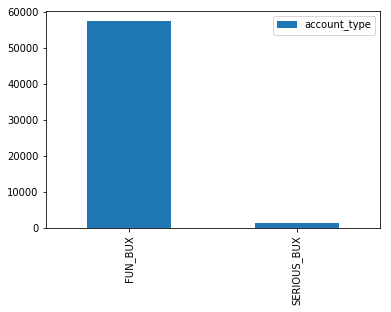

In [31]:
df, plot = column_summary('account_type',10)
df
plot

,network
Facebook Installs,15845
Organic,12553
TV,12314
Viral Invites,10037
Instagram Installs,1913
Appnext,1680
Google Adwords Search,1135
BUX Website,817
AdColony,555
Ligatus,435


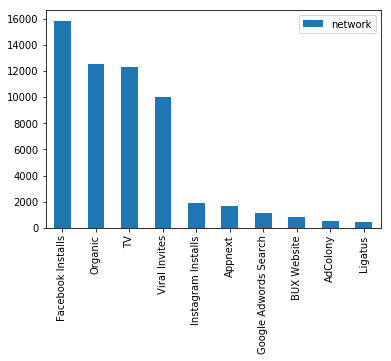

In [32]:
df, plot = column_summary('network',10)
df
plot

,trading_experience
NONE,45581
SOME,13254
EXPERT,4


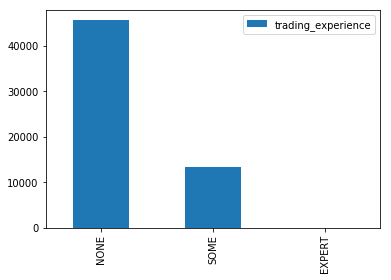

In [33]:
df, plot = column_summary('trading_experience',10)
df
plot

,gender
MALE,7040
FEMALE,402


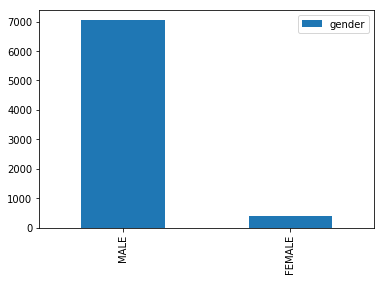

In [34]:
df, plot = column_summary('gender',10)
df
plot

### Transactions (cube_daily_user)

Daily transaction aggragation of user transactions

In [35]:
user_ids = tuple(users['user_id'].unique())

In [36]:
sample_user_ids = tuple(users[:5]['user_id'])
# str(sample_user_ids)
sample_user_ids

('031b0f17-9a45-4b1b-b7b4-027802ffad95',
 '010e236f-8ab5-4681-a146-273531d19d54',
 '011f6526-ab7e-4790-b289-5fa1faf69bc3',
 '0231bd62-6733-4f8b-9c57-87f4eb9e0aa1',
 '028e03b9-ab6d-4ede-85f2-ce6b6e38ad47')

In [37]:
daily_cube_columns = ['user_id', 'day_of_year', 'date', 'number_of_sessions', 'total_session_duration', 'account_status', 'trades_fb_commodities_open', 'trades_fb_commodities_profit', 'social_status_battles', 'social_status', 'conversion_to_sb']
daily_cube_columns = str(tuple(["a." + column for column in daily_cube_columns]))
daily_cube_columns = daily_cube_columns.replace('(', '').replace(')','').replace("'", "")
daily_cube_columns

'a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb'

### Query on a sample of users

query_trans = """

SELECT * FROM reporting.cube_daily_user WHERE user_id IN ('010e236f-8ab5-4681-a146-273531d19d54',
 '011f6526-ab7e-4790-b289-5fa1faf69bc3',
 '0231bd62-6733-4f8b-9c57-87f4eb9e0aa1',
 '028e03b9-ab6d-4ede-85f2-ce6b6e38ad47',
 '031eedbe-8154-4032-b9b7-157ac8131669') AND month = 2 AND year = 2017

"""

conn = vertica_python.connect(**conn_info)
cur = conn.cursor('dict')
cur.execute(query_trans)
df = pd.DataFrame(cur.fetchall())
df.head()

## Query on all users

In [38]:
len(users)

58839

sample_user_ids = tuple(users[:1000]['user_id'])
sample_user_ids[0:5]

In [39]:
daily_cube_columns

'a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb'

In [40]:
query_transactions = """

    SELECT a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb
    FROM reporting.cube_daily_user a 
    JOIN reporting.user_details b on b.user_id = a.user_id
    WHERE b.bux_account_created_dts::date  between '2017-02-01' and '2017-03-01'
    AND a.date between b.bux_account_created_dts::date and b.bux_account_created_dts::date + interval '3 weeks'
    

"""
query_transactions

"\n\n    SELECT a.user_id, a.day_of_year, a.date, a.number_of_sessions, a.total_session_duration, a.account_status, a.trades_fb_commodities_open, a.trades_fb_commodities_profit, a.social_status_battles, a.social_status, a.conversion_to_sb\n    FROM reporting.cube_daily_user a \n    JOIN reporting.user_details b on b.user_id = a.user_id\n    WHERE b.bux_account_created_dts::date  between '2017-02-01' and '2017-03-01'\n    AND a.date between b.bux_account_created_dts::date and b.bux_account_created_dts::date + interval '3 weeks'\n    \n\n"

In [41]:
conn = vertica_python.connect(**conn_info)
cur = conn.cursor('dict')
cur.execute(query_transactions)
cube_daily_user = pd.DataFrame(cur.fetchall())
cube_daily_user.head()

,user_id,day_of_year,date,number_of_sessions,total_session_duration,account_status,trades_fb_commodities_open,trades_fb_commodities_profit,social_status_battles,social_status,conversion_to_sb
0,000c5e5d-4e25-412d-951b-31167045eb95,60,2017-03-01,0,0,FUN_BUX,0,0.00,0,Following,0
1,000c5e5d-4e25-412d-951b-31167045eb95,61,2017-03-02,0,0,FUN_BUX,0,0.00,0,Following,0
2,000c5e5d-4e25-412d-951b-31167045eb95,62,2017-03-03,0,0,FUN_BUX,0,0.00,0,Following,0
3,000c5e5d-4e25-412d-951b-31167045eb95,65,2017-03-06,0,0,FUN_BUX,0,0.00,0,Following,0
4,000c5e5d-4e25-412d-951b-31167045eb95,66,2017-03-07,0,0,FUN_BUX,0,0.00,0,Following,0


In [46]:
len(cube_daily_user['user_id'].unique())

58045

In [47]:
len(cube_daily_user)

370117

In [48]:
len(cube_daily_user['user_id'].unique())

58045

In [49]:
cube_daily_user.to_csv('data/cube_daily_user_Feb_1_30days_cohort.csv')

In [521]:
pd.Series(cube_daily_user.columns)

0                          user_id
1                      day_of_year
2                             date
3               number_of_sessions
4           total_session_duration
5                   account_status
6       trades_fb_commodities_open
7     trades_fb_commodities_profit
8            social_status_battles
9                    social_status
10                conversion_to_sb
dtype: object

In [522]:
cube_daily_user.groupby('user_id').mean()

,day_of_year,number_of_sessions,total_session_duration,trades_fb_commodities_open,social_status_battles,conversion_to_sb
user_id,,,,,,
0001a0b6-fe20-47d2-a9f9-dde0af2ee132,40.000000,1.000000,661.000000,0.000000,0.000000,0.000000
00028e09-fcff-4368-9409-e9419efec176,38.000000,2.000000,256.000000,0.000000,0.000000,0.000000
0008181d-5863-4378-ba9a-00206346827b,41.000000,3.000000,8391.000000,0.000000,0.000000,0.000000
000a8509-5100-4f81-9487-85b71f77e2a6,46.200000,1.200000,1658.400000,0.000000,0.000000,0.000000
000ce685-75a4-4490-81a0-2efb786f8c87,46.500000,2.000000,297.500000,0.000000,0.000000,0.000000
000fc4bb-5b31-41b6-92e9-463f6ccef66f,37.000000,1.000000,146.000000,0.000000,0.000000,0.000000
001c9415-fc54-4695-b28e-c96255d5a211,38.000000,4.000000,454.000000,0.000000,0.000000,0.000000
001d03b9-d220-46bc-82ca-2d3898b6f810,38.000000,5.000000,313.000000,0.000000,0.000000,0.000000
002215ea-efd4-4f4d-9e92-b5cfb847ae37,35.500000,3.000000,543.500000,0.000000,0.000000,0.000000


In [523]:
cube_daily_user.groupby('user_id')['number_of_sessions', 'total_session_duration', 'trades_fb_commodities_open'].mean()[0:5]

,number_of_sessions,total_session_duration,trades_fb_commodities_open
user_id,,,
0001a0b6-fe20-47d2-a9f9-dde0af2ee132,1.0,661.0,0.0
00028e09-fcff-4368-9409-e9419efec176,2.0,256.0,0.0
0008181d-5863-4378-ba9a-00206346827b,3.0,8391.0,0.0
000a8509-5100-4f81-9487-85b71f77e2a6,1.2,1658.4,0.0
000ce685-75a4-4490-81a0-2efb786f8c87,2.0,297.5,0.0


## Current customer value (CurCV)

In [50]:
query_curcv = """ 

        SELECT a.user_id, sum(b.commission) as com, sum(b.dividend) as div, sum(b.financing_fee) as ff
        FROM (
        
        SELECT user_id
        FROM reporting.user_details
        WHERE bux_account_created_dts::date BETWEEN '2017-02-01' AND '2017-03-01') a
        

        LEFT JOIN (
        
        
        SELECT
        user_id
        , created_dts::date as report_date
        , sum(decode(transaction_type, 'COMMISSION',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as commission
        , sum(decode(transaction_type, 'DIVIDEND',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as dividend
        , sum(decode(transaction_type, 'FINANCING_FEE',-amount * nvl(b.exchange_rate, 1),0))::numeric(20,2) as financing_fee
        from reporting.transactions a
        left join reporting.exchange_rates_eur b on b.report_date = a.created_dts::date and b.currency = a.currency
        group by 1,2
        order by 1 ) b
        
        ON a.user_id = b.user_id
        GROUP BY a.user_id

"""

CurCV = sql_query(query_curcv)
CurCV[0:5]

,user_id,com,div,ff
0,62975554-fc1c-46c9-8a7c-80b8ed710284,None,None,None
1,84a09b40-e773-4ca5-8e0b-4dcfe5a34b00,None,None,None
2,0c743fbc-d056-4957-9c90-d92f893defc0,None,None,None
3,cfab8dd2-d4c8-490c-9452-581acd5ebdf7,None,None,None
4,a9727139-75e6-41b0-8428-6b2a7d2ff893,None,None,None


In [51]:
CurCV['total'] = CurCV['com'] + CurCV['div'] + CurCV['ff']

In [52]:
import numpy as np

In [53]:
serious_buxers = CurCV[pd.isnull(CurCV['total']) == False]['total']

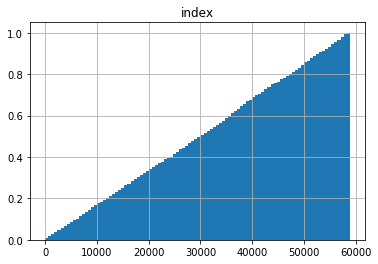

In [54]:
pd.DataFrame(serious_buxers).reset_index().hist(cumulative=True, normed=1, bins=100);

In [56]:
CurCV.to_csv('data/curCv_Feb_1_30days_cohort.csv')